## 1 Import Libraries 

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from PIL import Image
import keras
from tensorflow.keras.layers import BatchNormalization
from keras.utils import to_categorical 
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import scipy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator

In [3]:
import concurrent.futures
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
try:
    tf.config.experimental.set_memory_growth = True
except Exception as ex:
    print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
import multiprocessing
max_workers = multiprocessing.cpu_count()
max_workers

16

## 2  Load Dataset 

In [5]:
parent_folder_path = "IMG_CLASSES"

### 2.1  Adding Labels 

In [14]:

image_paths = []
class_labels = []


class_label_map = {}

for subfolder_name in os.listdir(parent_folder_path):

    class_label = int(subfolder_name.split(".")[0]) - 1
    
    class_label_map[class_label] = subfolder_name.split(".")[1].split(" ")[1]
    
    subfolder_path = os.path.join(parent_folder_path, subfolder_name)
    for image_name in os.listdir(subfolder_path):
        image_path = os.path.join(subfolder_path, image_name)
        
        image_paths.append(image_path)
        class_labels.append(class_label)

data = {"image_path": image_paths, "class_label": class_labels}
df = pd.DataFrame(data)


(class_label_map)

{0: 'Eczema',
 9: 'Warts',
 1: 'Melanoma',
 2: 'Atopic',
 3: 'Basal',
 4: 'Melanocytic',
 5: 'Benign',
 6: 'Psoriasis',
 7: 'Seborrheic',
 8: 'Tinea'}

In [10]:
df

,image_path,class_label
0,IMG_CLASSES\1. Eczema 1677\0_0.jpg,0
1,IMG_CLASSES\1. Eczema 1677\0_1.jpg,0
2,IMG_CLASSES\1. Eczema 1677\0_10.jpg,0
3,IMG_CLASSES\1. Eczema 1677\0_11.jpg,0
4,IMG_CLASSES\1. Eczema 1677\0_12.jpg,0
...,...,...
27148,IMG_CLASSES\9. Tinea Ringworm Candidiasis and ...,8
27149,IMG_CLASSES\9. Tinea Ringworm Candidiasis and ...,8
27150,IMG_CLASSES\9. Tinea Ringworm Candidiasis and ...,8
27151,IMG_CLASSES\9. Tinea Ringworm Candidiasis and ...,8


In [10]:
data_dir = 'IMG_CLASSES'

class_names = os.listdir(parent_folder_path)

for class_name in class_names:
    class_dir = os.path.join(parent_folder_path, class_name)
    num_images = len(os.listdir(class_dir))
    print("Class {}: {} images".format(class_name, num_images))

Class 1. Eczema 1677: 1677 images
Class 10. Warts Molluscum and other Viral Infections - 2103: 2103 images
Class 2. Melanoma 15.75k: 3140 images
Class 3. Atopic Dermatitis - 1.25k: 1257 images
Class 4. Basal Cell Carcinoma (BCC) 3323: 3323 images
Class 5. Melanocytic Nevi (NV) - 7970: 7970 images
Class 6. Benign Keratosis-like Lesions (BKL) 2624: 2079 images
Class 7. Psoriasis pictures Lichen Planus and related diseases - 2k: 2055 images
Class 8. Seborrheic Keratoses and other Benign Tumors - 1.8k: 1847 images
Class 9. Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k: 1702 images


<Axes: xlabel='class_label'>

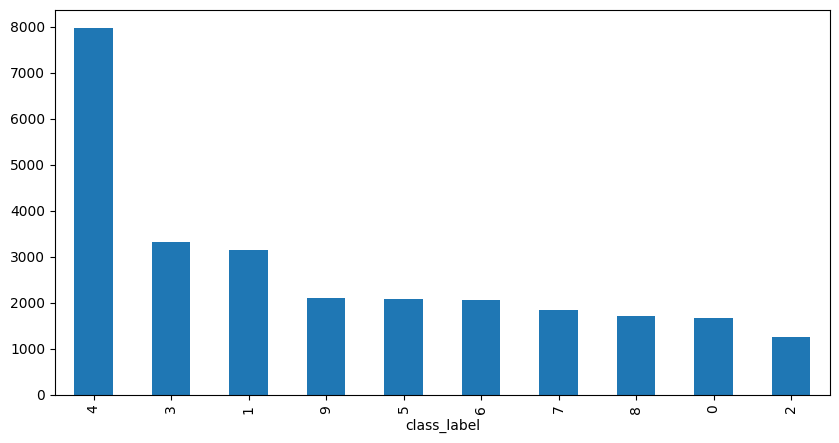

In [11]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
df['class_label'].value_counts().plot(kind='bar', ax=ax1)

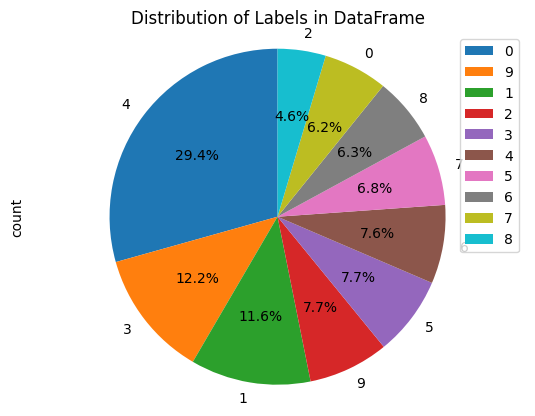

In [12]:
df['class_label'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Distribution of Labels in DataFrame')
plt.legend(df['class_label'].unique())
plt.show()

# Loading and resizing of images

In [13]:
max_images_per_class = 1000
df = df.groupby("class_label").apply(lambda x: x.head(max_images_per_class)).reset_index(drop=True)

C:\Users\barry\AppData\Local\Temp\ipykernel_3932\2558995546.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("class_label").apply(lambda x: x.head(max_images_per_class)).reset_index(drop=True)


<Axes: xlabel='class_label'>

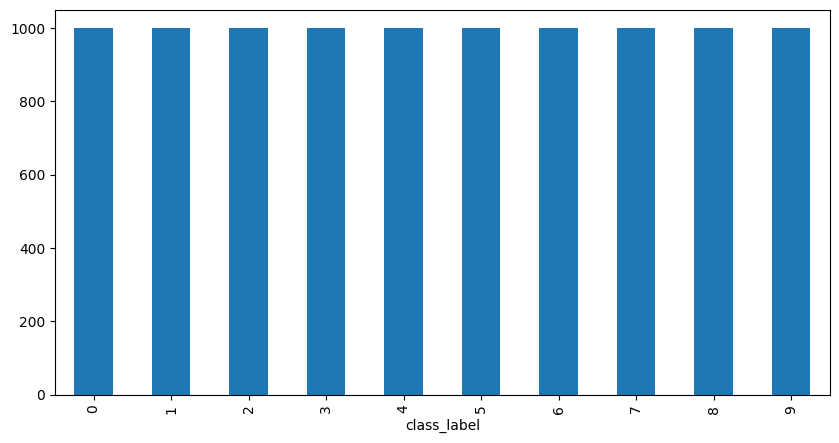

In [14]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
df['class_label'].value_counts().plot(kind='bar', ax=ax1)

## 4 Converting image to array 

In [15]:
def resize_image_array(image_path):
    return np.asarray(Image.open(image_path).resize((100,75)))

with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
    image_arrays = list(executor.map(resize_image_array, df['image_path'].tolist()))

df['image'] = image_arrays
del image_arrays
df

,image_path,class_label,image
0,IMG_CLASSES\1. Eczema 1677\0_0.jpg,0,"[[[143, 135, 130], [149, 138, 134], [151, 144,..."
1,IMG_CLASSES\1. Eczema 1677\0_1.jpg,0,"[[[196, 135, 118], [198, 137, 125], [197, 139,..."
2,IMG_CLASSES\1. Eczema 1677\0_10.jpg,0,"[[[91, 59, 58], [93, 64, 60], [99, 60, 57], [1..."
3,IMG_CLASSES\1. Eczema 1677\0_11.jpg,0,"[[[91, 95, 106], [90, 94, 104], [91, 95, 104],..."
4,IMG_CLASSES\1. Eczema 1677\0_12.jpg,0,"[[[141, 80, 62], [149, 83, 66], [156, 88, 70],..."
...,...,...,...
9995,IMG_CLASSES\10. Warts Molluscum and other Vira...,9,"[[[233, 183, 156], [234, 185, 161], [235, 188,..."
9996,IMG_CLASSES\10. Warts Molluscum and other Vira...,9,"[[[191, 138, 112], [187, 130, 102], [188, 133,..."
9997,IMG_CLASSES\10. Warts Molluscum and other Vira...,9,"[[[224, 198, 154], [224, 202, 160], [226, 204,..."
9998,IMG_CLASSES\10. Warts Molluscum and other Vira...,9,"[[[227, 168, 169], [227, 175, 174], [229, 183,..."


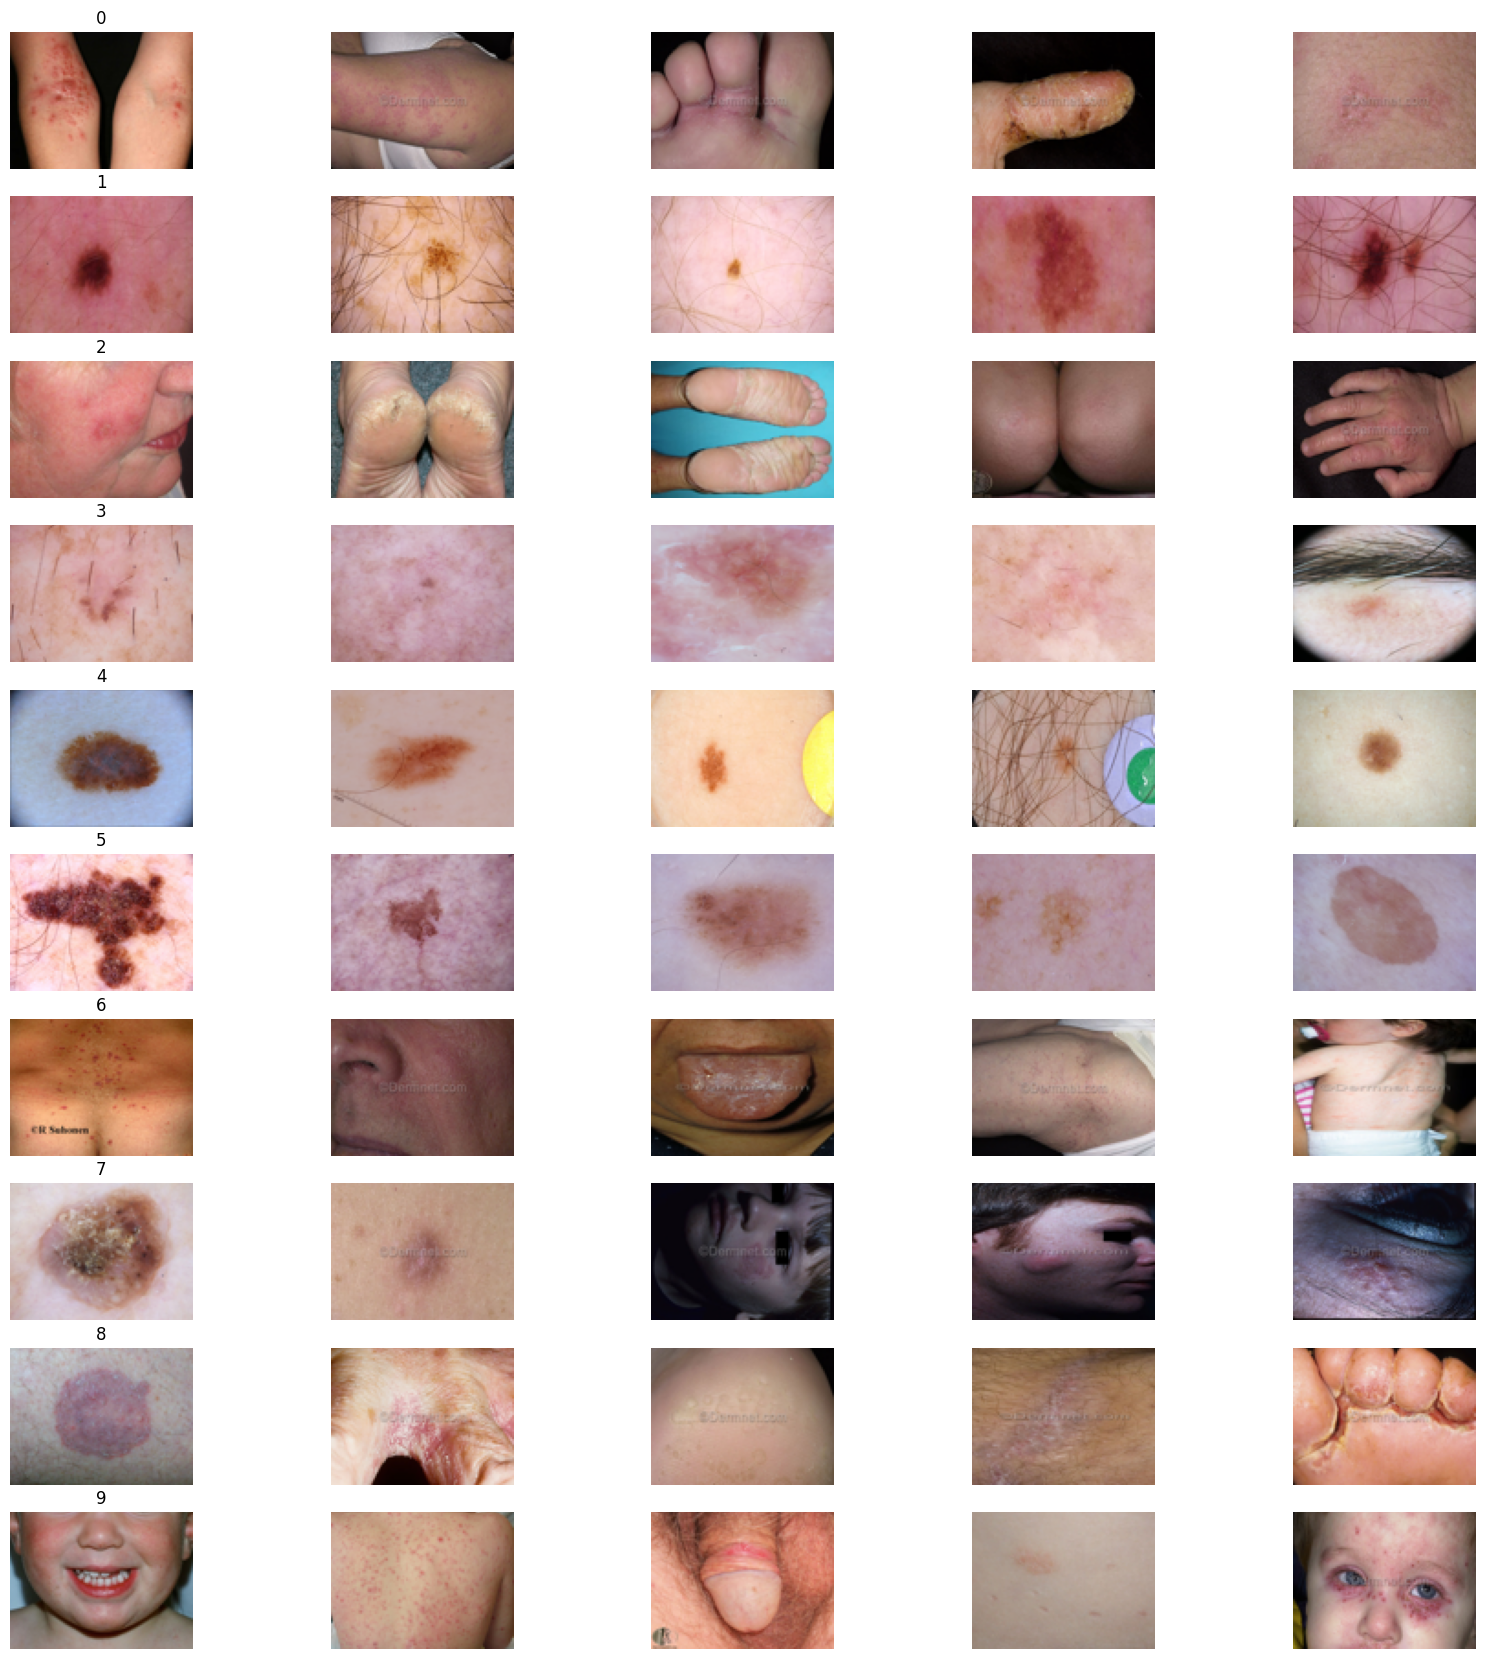

In [16]:
n_samples = 5
fig, m_axs = plt.subplots(10, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, df.sort_values(['class_label']).groupby('class_label')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

In [17]:
df['image'].map(lambda x: x.shape).value_counts()

image
(75, 100, 3)    10000
Name: count, dtype: int64

In [18]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [19]:
augmented_df = pd.DataFrame(columns=['image_path', 'class_label', 'image'])

for class_label in df['class_label'].unique():
    image_arrays = df.loc[df['class_label'] == class_label, 'image'].values
    
    num_images_needed = max_images_per_class - len(image_arrays)
    
    if num_images_needed > 0:
        selected_images = np.random.choice(image_arrays, size=num_images_needed)
        
        for image_array in selected_images:
            image_tensor = np.expand_dims(image_array, axis=0)
            
            augmented_images = datagen.flow(image_tensor, batch_size=1)
            
            for i in range(augmented_images.n):
                augmented_image_array = augmented_images.next()[0].astype('uint8')
                augmented_df = pd.concat([augmented_df, pd.DataFrame(list({'image_path': None, 'class_label': class_label, 'image': augmented_image_array}))], ignore_index=True)
    
    original_images_df = df.loc[df['class_label'] == class_label, ['image_path', 'class_label', 'image']]
    augmented_df = pd.concat([augmented_df, original_images_df], ignore_index=True)

df = augmented_df.groupby('class_label').head(max_images_per_class)

del augmented_df

df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [20]:
df.groupby('class_label').size()

class_label
0    1000
1    1000
2    1000
3    1000
4    1000
5    1000
6    1000
7    1000
8    1000
9    1000
dtype: int64

In [21]:
class_counts = df['class_label'].value_counts().sort_index()

print("Dataset Summary")
print("-" * 50)
print(f"{'Class Label':<15} {'Class Name':<30} {'Count':<10}")
print("-" * 50)
for class_label, class_name in class_label_map.items():
    count = class_counts[class_label]
    print(f"{class_label:<15} {class_name:<30} {count:<10}")
print("-" * 50)
print(f"{'Total':<45} {sum(class_counts):<10}")

Dataset Summary
--------------------------------------------------
Class Label     Class Name                     Count     
--------------------------------------------------
0               Eczema                         1000      
9               Warts                          1000      
1               Melanoma                       1000      
2               Atopic                         1000      
3               Basal                          1000      
4               Melanocytic                    1000      
5               Benign                         1000      
6               Psoriasis                      1000      
7               Seborrheic                     1000      
8               Tinea                          1000      
--------------------------------------------------
Total                                         10000     


In [22]:
features=df.drop(columns=['class_label','image_path'],axis=1)
target=df['class_label']

In [23]:
target.head()

0    6
1    4
2    1
3    4
4    4
Name: class_label, dtype: object

In [24]:
print(target.shape,features.shape)

(10000,) (10000, 1)


## 5. Spilting the dataset

In [25]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20,random_state=1234)

In [26]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


## 6. Normalization

In [27]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [28]:
y_train = to_categorical(y_train_o,num_classes = 10)
y_test = to_categorical(y_test_o,num_classes = 10)

In [29]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)

In [30]:
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

# Building the model

In [31]:
num_classes = 10
from keras.optimizers import SGD
input_shape = (75,100,3)

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

# DenseNet121
model = Sequential()
model.add(DenseNet121(include_top=False, weights='imagenet', input_shape=input_shape))
#model.add(MaxPooling2D(2, 2))
#model.add(Conv2D(32, (3, 3), activation='relu'))
#model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

opt = SGD(lr=0.01, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

c:\Users\barry\anaconda3\envs\tf2.10\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [32]:

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.005)

# Model Fitting

In [33]:
epochs = 20
batch_size=128
history = model.fit(x=x_train, y=y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_validate,y_validate), callbacks=learning_rate_reduction)

Epoch 1/20
57/57 [==============================] - 26s 220ms/step - loss: 1.5557 - accuracy: 0.4536 - val_loss: 2.0326 - val_accuracy: 0.4263 - lr: 0.0100
Epoch 2/20
57/57 [==============================] - 11s 191ms/step - loss: 0.9618 - accuracy: 0.6388 - val_loss: 1.3221 - val_accuracy: 0.5612 - lr: 0.0100
Epoch 3/20
57/57 [==============================] - 11s 191ms/step - loss: 0.6777 - accuracy: 0.7492 - val_loss: 1.2632 - val_accuracy: 0.5938 - lr: 0.0100
Epoch 4/20
57/57 [==============================] - 11s 193ms/step - loss: 0.4882 - accuracy: 0.8219 - val_loss: 1.5014 - val_accuracy: 0.5962 - lr: 0.0100
Epoch 5/20
57/57 [==============================] - 11s 192ms/step - loss: 0.4029 - accuracy: 0.8610 - val_loss: 1.3202 - val_accuracy: 0.6250 - lr: 0.0100
Epoch 6/20
57/57 [==============================] - 11s 193ms/step - loss: 0.3401 - accuracy: 0.8835 - val_loss: 1.1707 - val_accuracy: 0.6650 - lr: 0.0100
Epoch 7/20
57/57 [==============================] - 11s 193ms/st

# Evaluation

63/63 [==============================] - 1s 19ms/step


<Axes: >

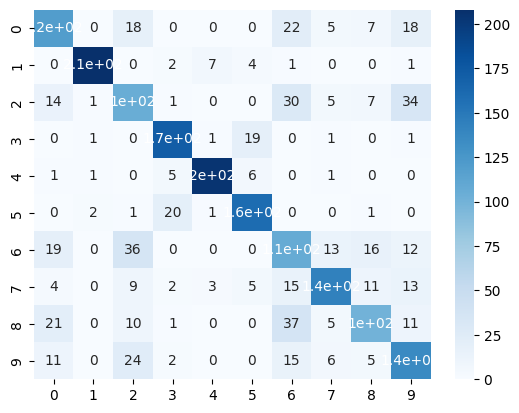

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get the predicted probabilities for the test set
y_pred_prob = model.predict(x_test)

# Find the class with the highest probability for each sample
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

# Plot the confusion matrix using Seaborn
sns.heatmap(cm, annot=True, cmap='Blues')

# Plotting

In [35]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

# Calculate evaluation metrics
accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred)
precision = precision_score(np.argmax(y_test, axis=1), y_pred, average='macro')
recall = recall_score(np.argmax(y_test, axis=1), y_pred, average='macro')
f1 = f1_score(np.argmax(y_test, axis=1), y_pred, average='macro')
kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Kappa score: {kappa:.4f}")

Accuracy: 0.7275
Precision: 0.7286
Recall: 0.7229
F1-score: 0.7240
Kappa score: 0.6971


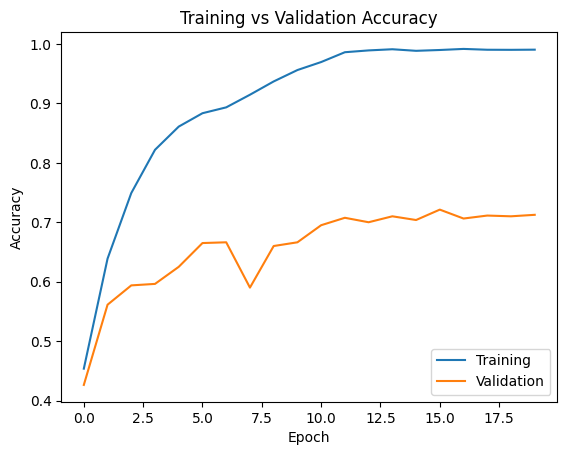

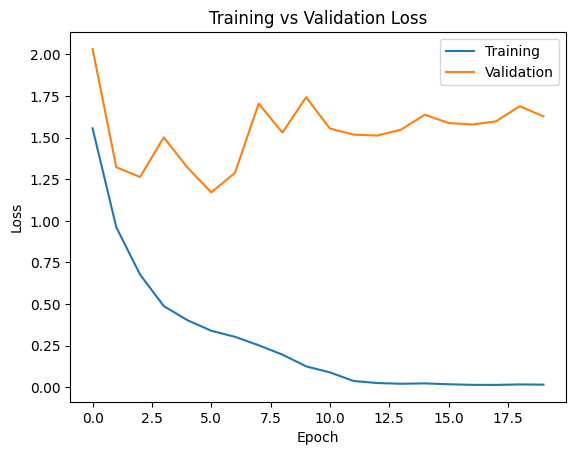

In [37]:
import matplotlib.pyplot as plt

# Get training and testing accuracy and loss histories
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Plot training and testing accuracy curves
plt.plot(training_accuracy)
plt.plot(validation_accuracy)
plt.title('Training vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

# Plot training and testing loss curves
plt.plot(training_loss)
plt.plot(validation_loss)
plt.title('Training vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [38]:
model.save('model_new.h5')

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1
